# Задание 1

Импортировать данные northwind.db

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



con=sqlite3.Connection('/content/northwind.db')
df=pd.read_sql('''with revenues as (SELECT 
 shipregion, 
 customerid,
 orders.orderid,
 orderdate, 
  productid, 
 (unitprice*quantity*(1-discount)) as revenue
from orders,"order details" 
on orders.orderid="order details".orderid
group by orderdate,shipregion,customerid,orders.orderid, productid) 
SELECT orderdate,shipregion, customerid,sum(revenue) as revenuedaily, count(orderid) as ordersdaily
from revenues
group by orderdate;''',con=con)


In [ ]:
df

,orderdate,shipregion,customerid,revenuedaily,ordersdaily
0,2016-07-04,Western Europe,VINET,440.0000,3
1,2016-07-05,Western Europe,TOMSP,1863.4000,2
2,2016-07-08,South America,HANAR,2206.6600,6
3,2016-07-09,Western Europe,SUPRD,3597.9000,3
4,2016-07-10,South America,HANAR,1444.8000,3
...,...,...,...,...,...
475,2018-04-30,Southern Europe,FRANS,2525.3500,8
476,2018-05-01,North America,SAVEA,5448.5700,10
477,2018-05-04,Western Europe,DRACD,2473.9300,5
478,2018-05-05,Western Europe,LEHMS,7632.4750,12


# Задание 2	
С помощью  matplotlib и seaborn построить дэшборд по полученным данным, описывающий заказы:



###  2.1.	Создать линейные графики, описывающие историю выручки (revenuedaily) и числа заказов (ordersdaily) (суммарно за неделю)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   orderdate     480 non-null    object 
 1   shipregion    480 non-null    object 
 2   customerid    480 non-null    object 
 3   revenuedaily  480 non-null    float64
 4   ordersdaily   480 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 18.9+ KB


In [ ]:
# привожу orderdate к типу datetime, чтобы можно было изменить гранулярность индексированного временного столбца
df['orderdate'] = pd.to_datetime(df['orderdate'])

In [ ]:
# Группировка данных по неделям
df2 = df.set_index('orderdate').resample('1W')['ordersdaily', 'revenuedaily'].sum().reset_index()

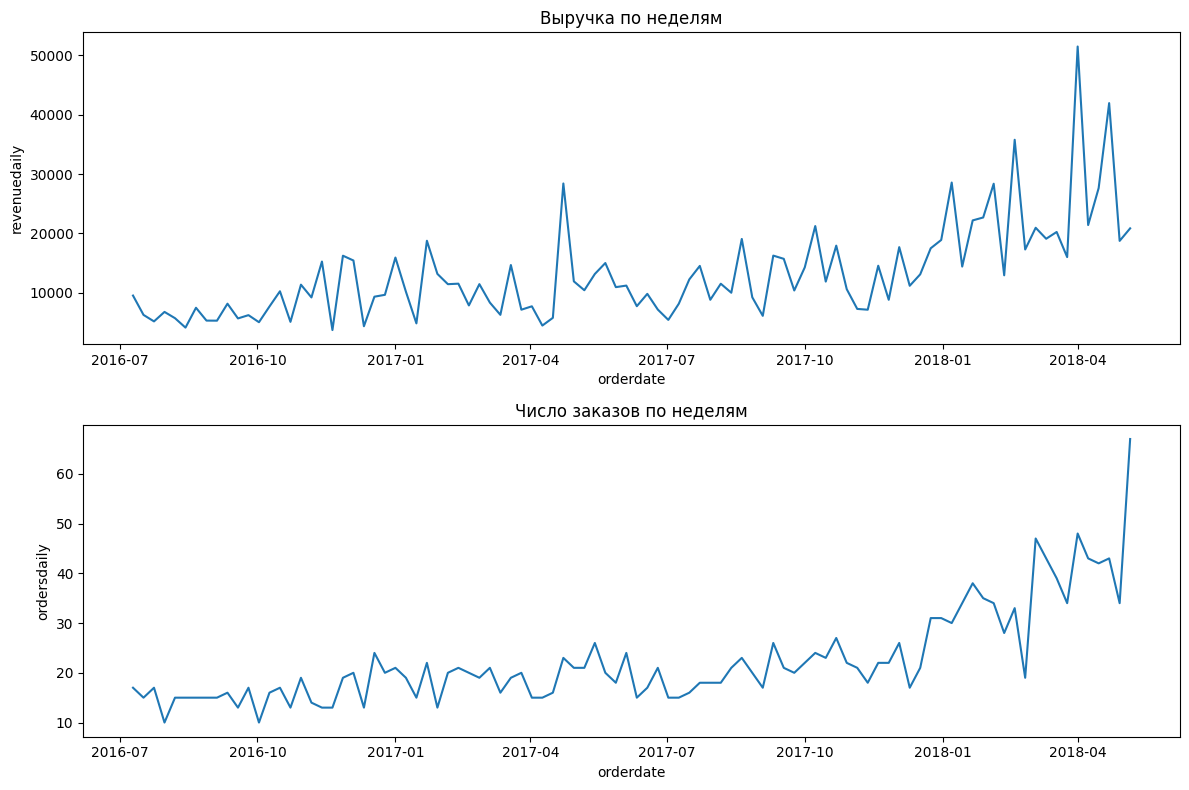

In [ ]:
# Создание линейных графиков для выручки и числа заказов
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=ax1)
ax1.set_title('Выручка по неделям')
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=ax2)
ax2.set_title('Число заказов по неделям')

plt.tight_layout()
plt.show()


### 2.2.	Создать круговую диаграмму, описывающую долю региона (shipregion) в сумме выручки (revenue) за весь период

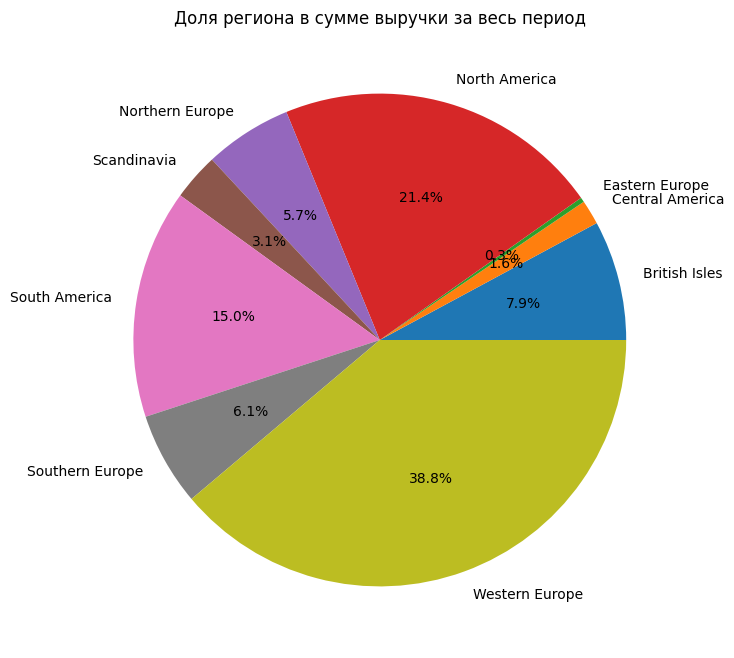

In [ ]:
# суммарный доход за весь период для каждого региона
revenue_by_region = df.groupby('shipregion')['revenuedaily'].sum().reset_index()

# Создание круговой диаграммы
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(data=revenue_by_region, x=revenue_by_region['revenuedaily'], labels=revenue_by_region['shipregion'], autopct='%1.1f%%')
ax.set_title('Доля региона в сумме выручки за весь период')
plt.show()


### 2.3.	Создать столбчатую диаграмму, описывающую выручку клиентов, относящихся к классу A. Согласно ABC анализу это список клиентов, которые приносят 80% суммарной выручки за период.

In [ ]:
# Определение списка клиентов класса A
total_revenue = df['revenuedaily'].sum()
df_sorted = df.groupby('customerid')['revenuedaily'].sum().sort_values(ascending=False)
cumulative_sum = df_sorted.cumsum()
customers_a = cumulative_sum[cumulative_sum <= 0.8 * total_revenue].index.tolist()

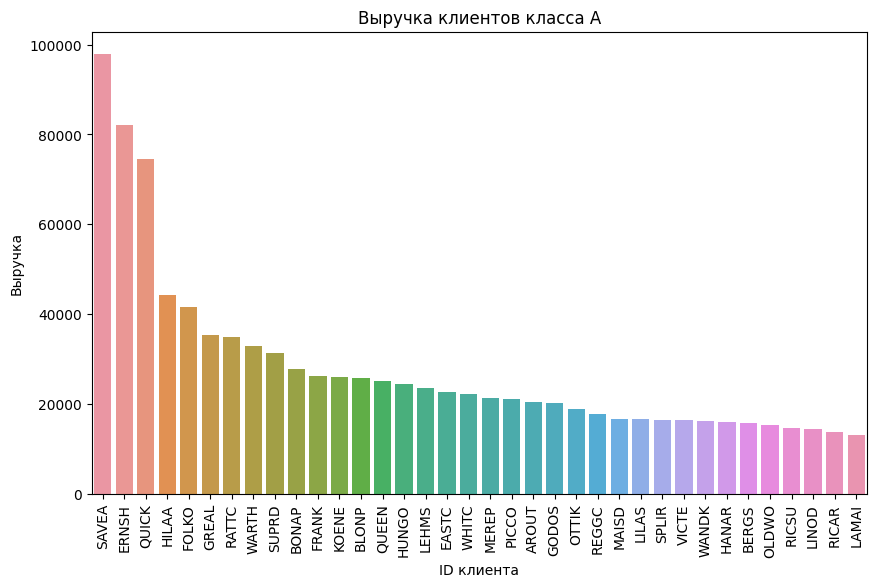

In [ ]:
# Создание столбчатой диаграммы
# Отсортирую клиентов по убыванию выручки
customers_a_revenue = df[df['customerid'].isin(customers_a)].groupby('customerid')['revenuedaily'].sum().reset_index().sort_values('revenuedaily', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=customers_a_revenue['customerid'], y=customers_a_revenue['revenuedaily'])
ax.set_title('Выручка клиентов класса A')
ax.set_xlabel('ID клиента')
ax.set_ylabel('Выручка')
ax.set_xticklabels(customers_a_revenue['customerid'], rotation=90)
plt.show()


### 2.4.	Создать сетку графиков из 4 вложенных графиков и в каждый из них передать диаграммы из пп.2.1-2.3

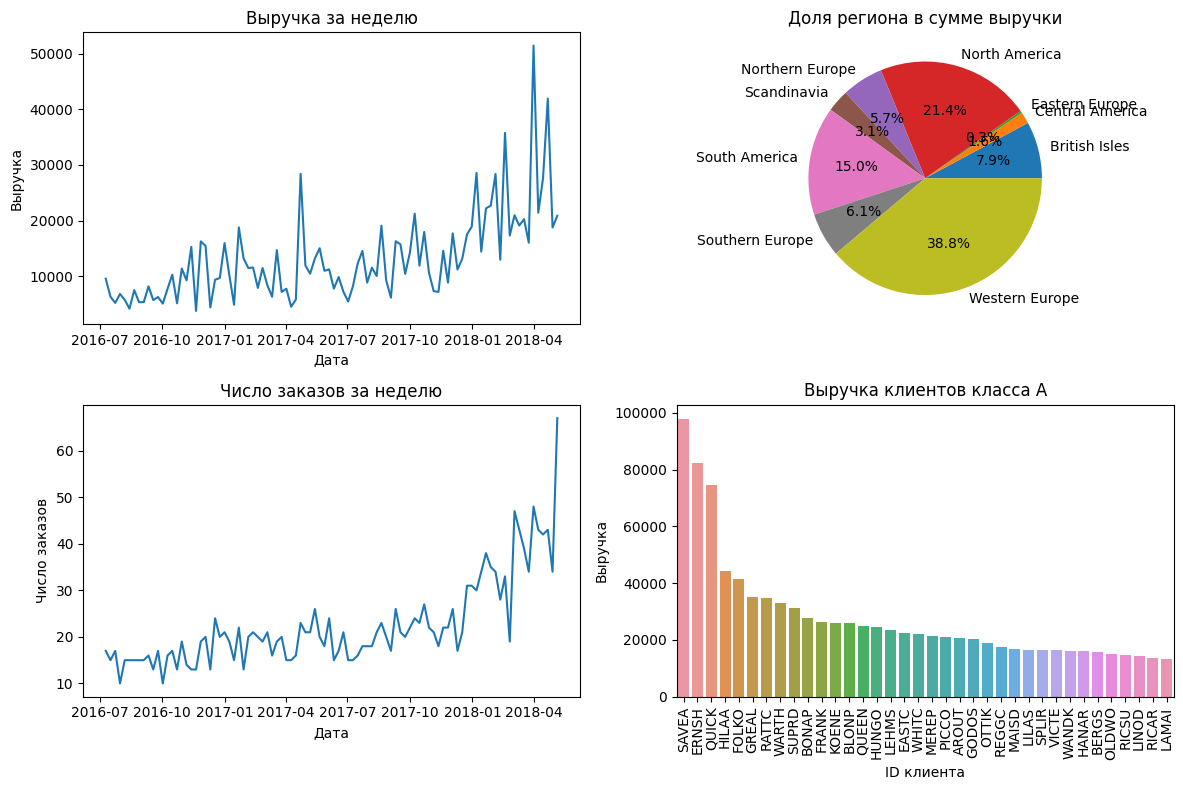

In [ ]:
# Создание сетки из 4 вложенных графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# График 1: линейный график выручки за неделю
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=axs[0, 0])

axs[0, 0].set_title('Выручка за неделю')
axs[0, 0].set_xlabel('Дата')
axs[0, 0].set_ylabel('Выручка')

# График 2: линейный график числа заказов за неделю
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=axs[1, 0])
axs[1, 0].set_title('Число заказов за неделю')
axs[1, 0].set_xlabel('Дата')
axs[1, 0].set_ylabel('Число заказов')

# График 3: круговая диаграмма доли региона в сумме выручки
axs[0, 1].pie(data=revenue_by_region, x=revenue_by_region['revenuedaily'], labels=revenue_by_region['shipregion'], autopct='%1.1f%%')
axs[0, 1].set_title('Доля региона в сумме выручки')

# График 4: столбчатая диаграмма выручки клиентов класса A
sns.barplot(x=customers_a_revenue['customerid'], y=customers_a_revenue['revenuedaily'], ax=axs[1, 1])
axs[1, 1].set_title('Выручка клиентов класса A')
axs[1, 1].set_xlabel('ID клиента')
axs[1, 1].set_ylabel('Выручка')
axs[1, 1].set_xticklabels(customers_a_revenue['customerid'], rotation=90)

plt.tight_layout()
plt.show()


# Задание 3	
Изменить на графиках 2.1 тип линии  на штрихованную линию.

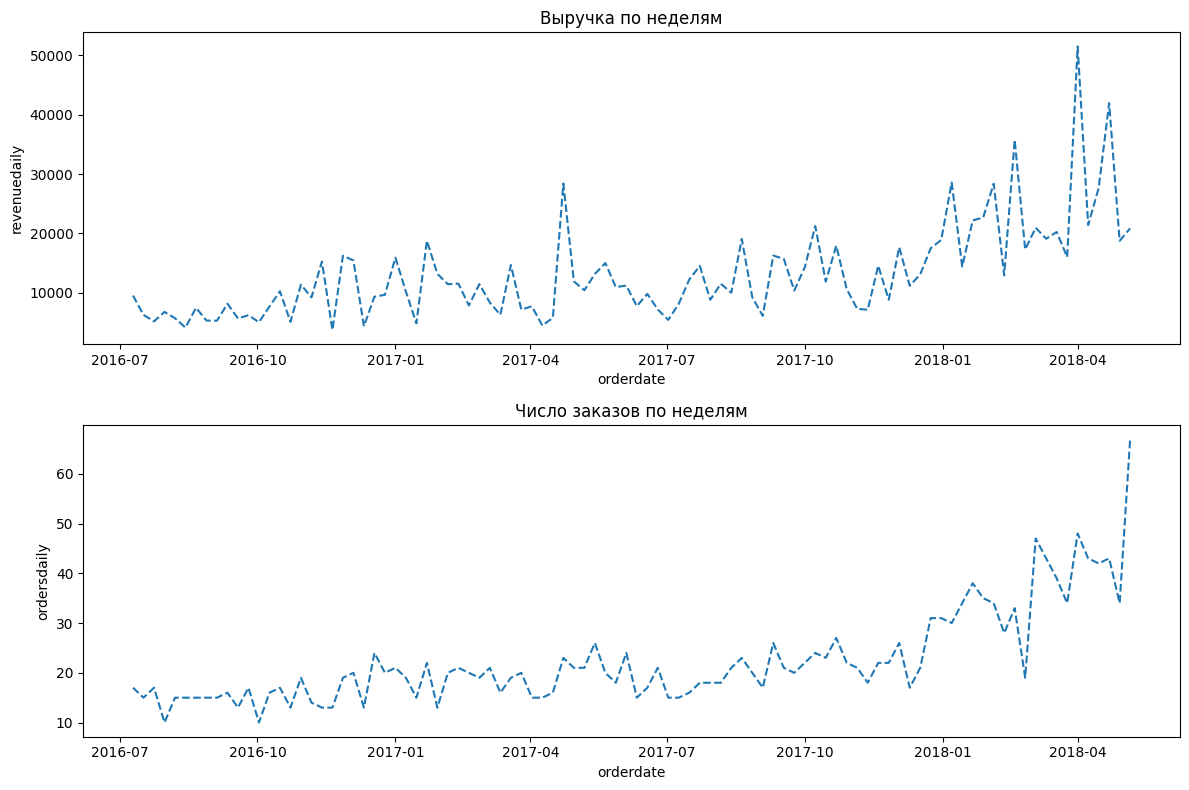

In [ ]:
# Создание линейных графиков для выручки и числа заказов
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=ax1, linestyle='dashed')
ax1.set_title('Выручка по неделям')
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=ax2, linestyle='dashed')
ax2.set_title('Число заказов по неделям')

plt.tight_layout()
plt.show()


# Задание 4	
Добавить на график продаж заливку цветом под графиком и  изменить цвета (выручка синим цветом, а продажи красным цветом.

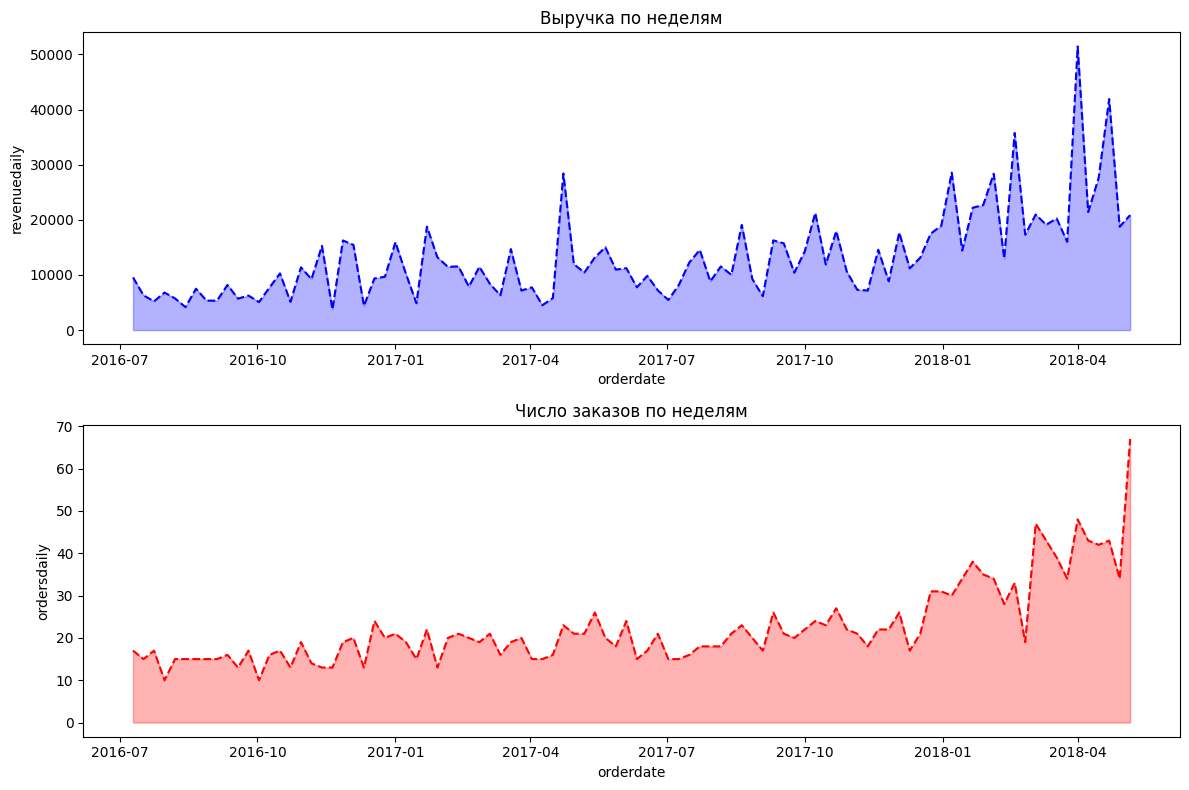

In [ ]:
# Создание линейных графиков для выручки и числа заказов
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=ax1, linestyle='dashed', color='blue')
ax1.fill_between(df2['orderdate'], df2['revenuedaily'], alpha=0.3, color='blue')
ax1.set_title('Выручка по неделям')
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=ax2, linestyle='dashed', color='red')
ax2.fill_between(df2['orderdate'], df2['ordersdaily'], alpha=0.3, color='red')
ax2.set_title('Число заказов по неделям')

plt.tight_layout()
plt.show()



# Задание 5	
Добавить заливку фона для графика 2.1 описывающего историю выручки

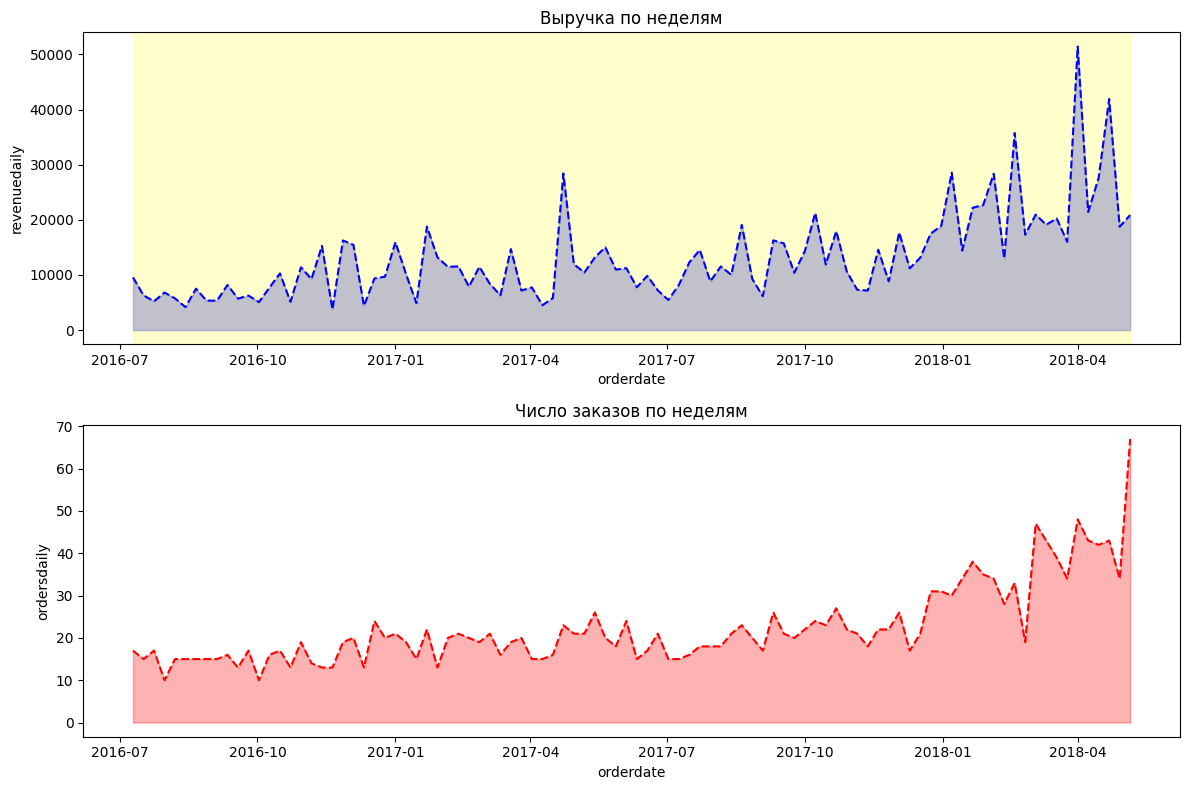

In [ ]:
# Создание линейных графиков для выручки и числа заказов
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=ax1, linestyle='dashed', color='blue')
ax1.fill_between(df2['orderdate'], df2['revenuedaily'], alpha=0.3, color='blue')
ax1.axvspan(df2['orderdate'].iloc[0], df2['orderdate'].iloc[-1], color='yellow', alpha=0.2)
ax1.set_title('Выручка по неделям')


sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=ax2, linestyle='dashed', color='red')
ax2.fill_between(df2['orderdate'], df2['ordersdaily'], alpha=0.3, color='red')
ax2.set_title('Число заказов по неделям')

plt.tight_layout()
plt.show()

# Задание 6	
Добавить заголовок для всей сетки, и для каждого графика в отдельности

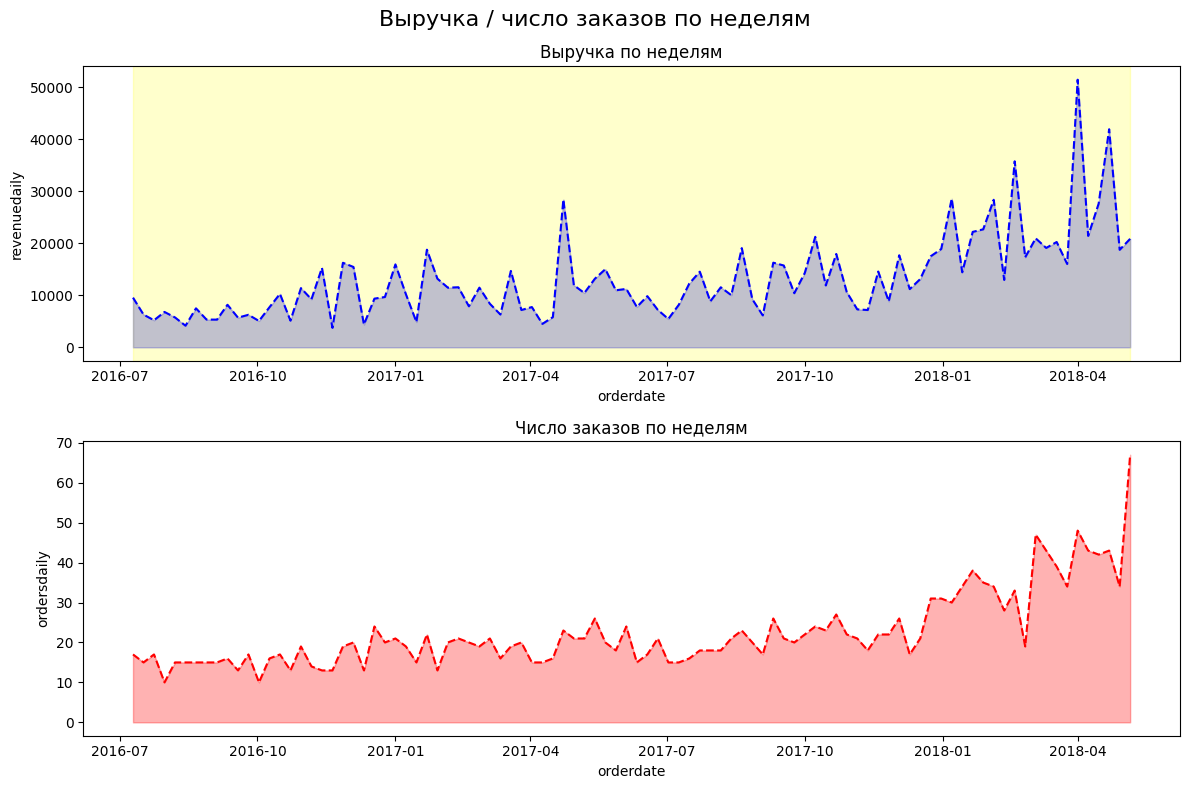

In [ ]:
# Создание линейных графиков для выручки и числа заказов
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
fig.suptitle('Выручка / число заказов по неделям', fontsize=16)
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=ax1, linestyle='dashed', color='blue')
ax1.fill_between(df2['orderdate'], df2['revenuedaily'], alpha=0.3, color='blue')
ax1.axvspan(df2['orderdate'].iloc[0], df2['orderdate'].iloc[-1], color='yellow', alpha=0.2)
ax1.set_title('Выручка по неделям')


sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=ax2, linestyle='dashed', color='red')
ax2.fill_between(df2['orderdate'], df2['ordersdaily'], alpha=0.3, color='red')
ax2.set_title('Число заказов по неделям')

plt.tight_layout()
plt.show()

# Задание 7	
В круговой диаграмме сделать выделение клина, описывающего регион с самой большой долей (выдвинуть его немного, относительно остальных клиньев)

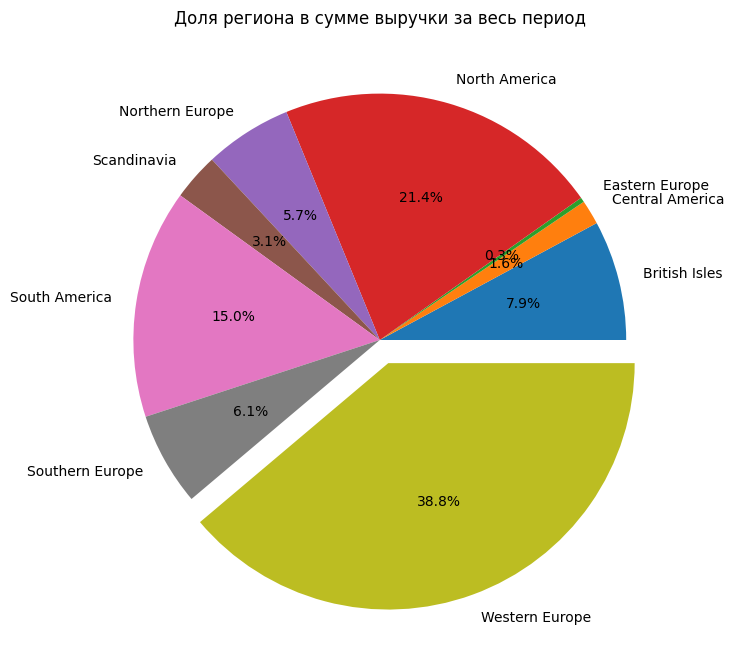

In [ ]:
# Находим индекс региона с максимальной выручкой
max_shipregion = revenue_by_region[revenue_by_region['revenuedaily'] == revenue_by_region['revenuedaily'].max()]
max_index = max_shipregion['shipregion'].iloc[0]

# Создание массива explode для выделения клина
explode = [0 if region != max_index else 0.1 for region in revenue_by_region['shipregion']]

# Создание круговой диаграммы с выделенным клином
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(data=revenue_by_region, x=revenue_by_region['revenuedaily'], labels=revenue_by_region['shipregion'], autopct='%1.1f%%', explode=explode)
ax.set_title('Доля региона в сумме выручки за весь период')
plt.show()

# Задание 8	
Заменить в столбчатой диаграмме палитру базовую на смешанную самостоятельно из зеленого и желтого цвета

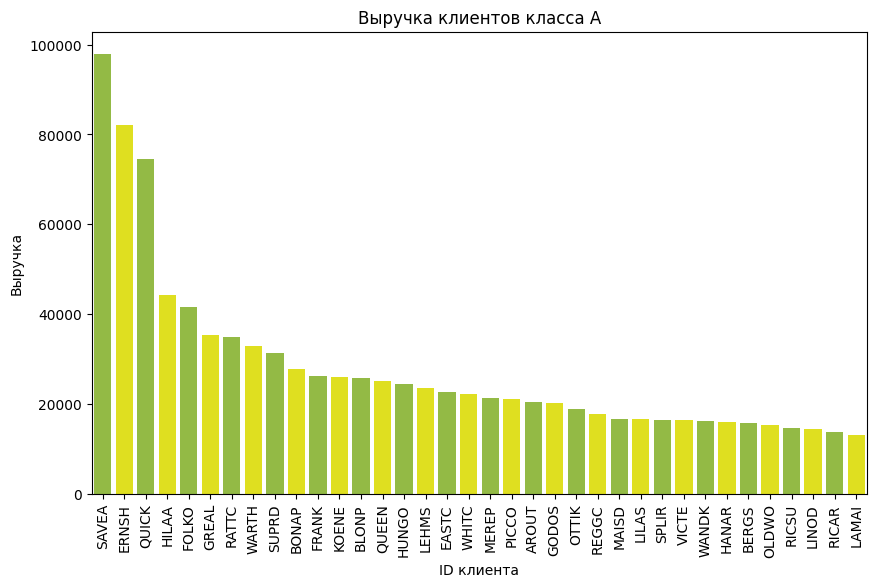

In [ ]:
# Создание столбчатой диаграммы

my_palette = ["#9ACD32", "#FFFF00"] # список из зеленого и желтого цветов

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=customers_a_revenue['customerid'], y=customers_a_revenue['revenuedaily'], palette=my_palette)
ax.set_title('Выручка клиентов класса A')
ax.set_xlabel('ID клиента')
ax.set_ylabel('Выручка')
ax.set_xticklabels(customers_a_revenue['customerid'], rotation=90)
plt.show()

# Задание 9	
Изменить размер всей сетки графиков в полтора раза (увеличить и по ширине и по высоте)

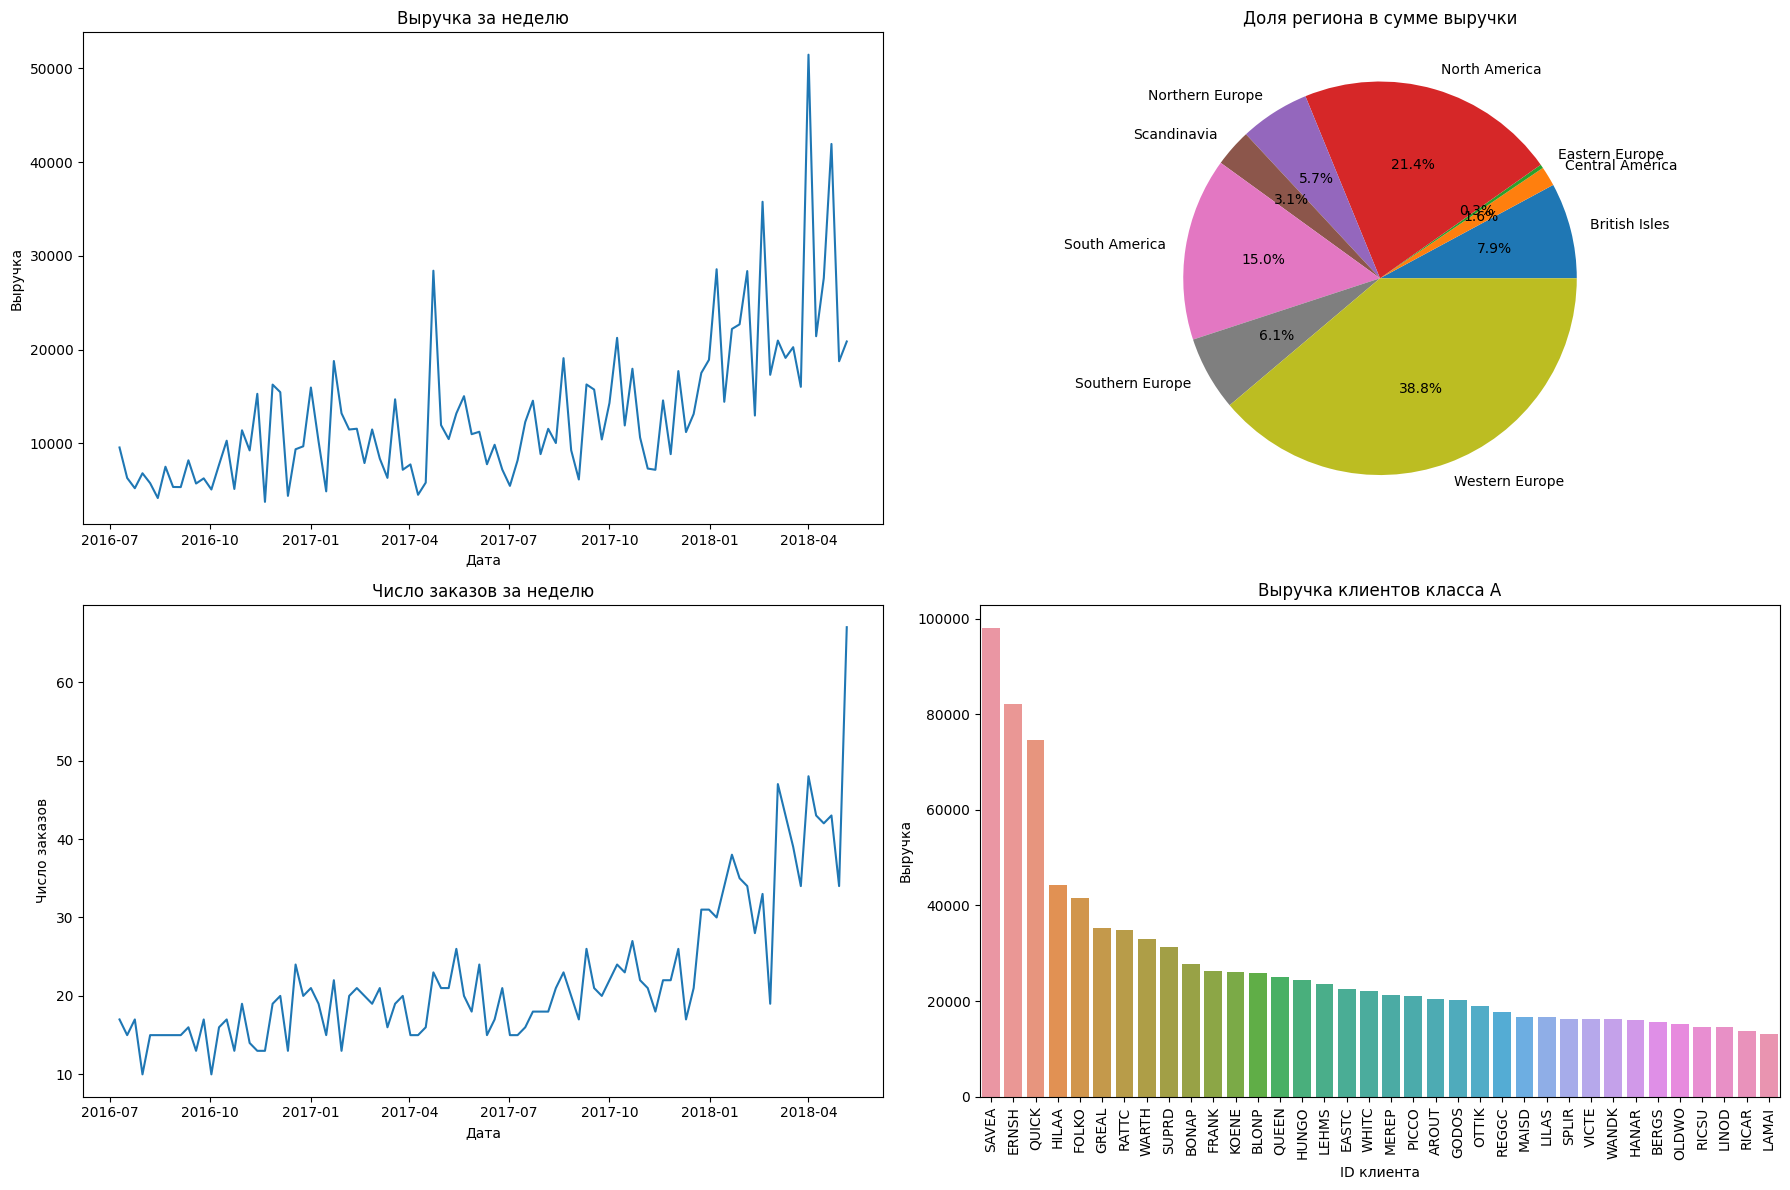

In [ ]:
# Создание сетки из 4 вложенных графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12 * 1.5, 8 * 1.5))

# График 1: линейный график выручки за неделю
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=axs[0, 0])

axs[0, 0].set_title('Выручка за неделю')
axs[0, 0].set_xlabel('Дата')
axs[0, 0].set_ylabel('Выручка')

# График 2: линейный график числа заказов за неделю
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=axs[1, 0])
axs[1, 0].set_title('Число заказов за неделю')
axs[1, 0].set_xlabel('Дата')
axs[1, 0].set_ylabel('Число заказов')

# График 3: круговая диаграмма доли региона в сумме выручки
axs[0, 1].pie(data=revenue_by_region, x=revenue_by_region['revenuedaily'], labels=revenue_by_region['shipregion'], autopct='%1.1f%%')
axs[0, 1].set_title('Доля региона в сумме выручки')

# График 4: столбчатая диаграмма выручки клиентов класса A
sns.barplot(x=customers_a_revenue['customerid'], y=customers_a_revenue['revenuedaily'], ax=axs[1, 1])
axs[1, 1].set_title('Выручка клиентов класса A')
axs[1, 1].set_xlabel('ID клиента')
axs[1, 1].set_ylabel('Выручка')
axs[1, 1].set_xticklabels(customers_a_revenue['customerid'], rotation=90)

plt.tight_layout()
plt.show()


# Задание 10	
Добавить сетку с линиями серого цвета на графики 2.1 и 2.3

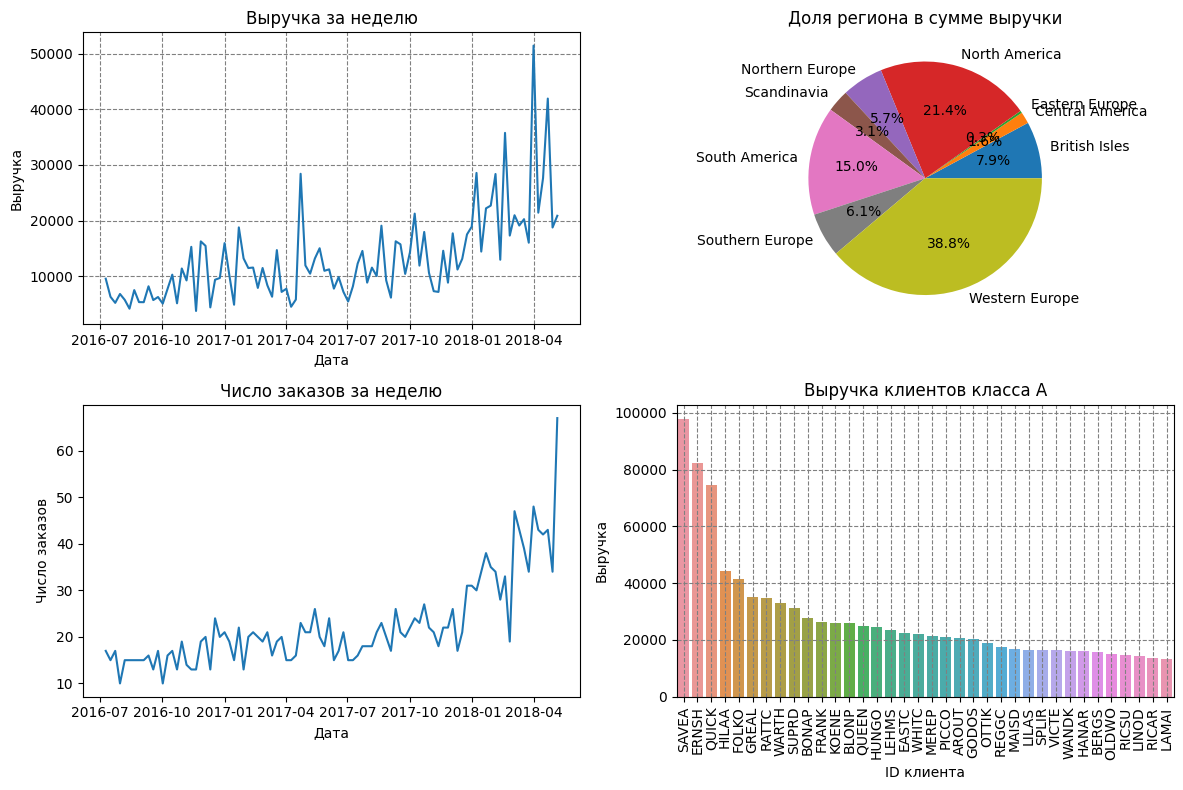

In [ ]:
# Создание сетки из 4 вложенных графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# График 1: линейный график выручки за неделю
sns.lineplot(data = df2, x='orderdate', y='revenuedaily', ax=axs[0, 0])

axs[0, 0].set_title('Выручка за неделю')
axs[0, 0].set_xlabel('Дата')
axs[0, 0].set_ylabel('Выручка')
axs[0, 0].grid(color='grey', linestyle='--')

# График 2: линейный график числа заказов за неделю
sns.lineplot(data = df2, x='orderdate', y='ordersdaily', ax=axs[1, 0])
axs[1, 0].set_title('Число заказов за неделю')
axs[1, 0].set_xlabel('Дата')
axs[1, 0].set_ylabel('Число заказов')

# График 3: круговая диаграмма доли региона в сумме выручки
axs[0, 1].pie(data=revenue_by_region, x=revenue_by_region['revenuedaily'], labels=revenue_by_region['shipregion'], autopct='%1.1f%%')
axs[0, 1].set_title('Доля региона в сумме выручки')

# График 4: столбчатая диаграмма выручки клиентов класса A
sns.barplot(x=customers_a_revenue['customerid'], y=customers_a_revenue['revenuedaily'], ax=axs[1, 1])
axs[1, 1].set_title('Выручка клиентов класса A')
axs[1, 1].set_xlabel('ID клиента')
axs[1, 1].set_ylabel('Выручка')
axs[1, 1].set_xticklabels(customers_a_revenue['customerid'], rotation=90)
axs[1, 1].grid(color='grey', linestyle='--')

plt.tight_layout()
plt.show()